In [2]:
import pandas as pd
import numpy as np

### Modeling perimeter

In [33]:
tconst = pd.read_parquet("../data/edited_data/datamart.db/tconst")

In [34]:
title_ratings = pd.read_parquet("../data/edited_data/datamart.db/title_ratings").set_index("tconst")

In [35]:
title_name_avg_ratings = pd.read_parquet("../data/edited_data/intermediate.db/title_name_avg_ratings")
title_genres_avg_ratings = pd.read_parquet("../data/edited_data/intermediate.db/title_genres_avg_ratings")
primary_title = pd.read_parquet("../data/edited_data/intermediate.db/primary_title")
title_budget = pd.read_parquet("../data/edited_data/intermediate.db/title_budget")

In [36]:
title_budget.head()

,title,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross,titleBasicsFlag,nObs
tconst,,,,,,,,
tt0443649,10000bc,2008-03-07,"10,000 B.C.",105000000.0,94784201.0,269065678.0,True,1
tt0211181,102dalmatians,2000-11-22,102 Dalmatians,85000000.0,66941559.0,66941559.0,True,1
tt1179933,10cloverfieldlane,2016-01-04,10 Cloverfield Lane,5000000.0,72082999.0,108286422.0,True,1
tt3453052,10daysinamadhouse,2015-11-11,10 Days in a Madhouse,12000000.0,14616.0,14616.0,True,1
tt0147800,10thingsihateaboutyou,1999-03-31,10 Things I Hate About You,13000000.0,38177966.0,60413950.0,True,1


In [155]:
data = (
    tconst.set_index("tconst")
    .join(title_name_avg_ratings)
    .join(title_genres_avg_ratings)
    .join(title_budget)
    .join(primary_title)
    .join(title_ratings, how="inner")
)

In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277451 entries, tt0000038 to tt9916720
Data columns (total 19 columns):
averageRating_name      199591 non-null float64
numVotes_name           199591 non-null float64
titleType               277451 non-null object
averageRating_genres    277451 non-null float64
numVotes_genres         277451 non-null float64
title                   3978 non-null object
ReleaseDate             3885 non-null datetime64[ns]
Movie                   3978 non-null object
ProductionBudget        3978 non-null float64
DomesticGross           3978 non-null float64
WorldwideGross          3978 non-null float64
titleBasicsFlag         3978 non-null object
nObs                    3978 non-null float64
primaryTitle            277451 non-null object
nLetters                277451 non-null float64
nCapitalLetters         277451 non-null float64
nWords                  277451 non-null float64
averageRating           277451 non-null float64
numVotes                277451 no

In [158]:
data = data.drop(
    columns=[
        "numVotes",
        "title", 
        "titleType", 
        "ReleaseDate", 
        "Movie", 
        "titleBasicsFlag", 
        "primaryTitle", 
        "DomesticGross", 
        "WorldwideGross"], 
    axis=1
)

In [159]:
data.to_parquet("../data/edited_data/modeling/data")

### target
#### discretisation of target variable

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

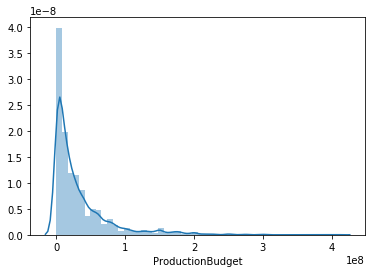

In [161]:
sns.distplot(data.ProductionBudget.dropna())

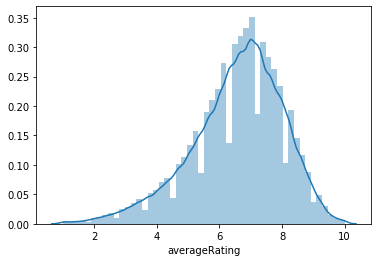

In [162]:
sns.distplot(data.averageRating)

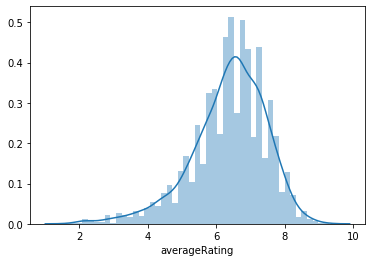

In [163]:
sns.distplot(data.dropna()["averageRating"])

### modeling

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [128]:
perimeter = data.dropna()
mean_avg_ratings = np.median(perimeter.averageRating)
print(mean_avg_ratings)

6.5


In [129]:
X = perimeter.drop(columns=["averageRating"], axis=1)
y = (perimeter.averageRating > mean_avg_ratings).astype(int)

In [130]:
y.head()

tconst
tt0028249    1
tt0036628    1
tt0039416    1
tt0041841    1
tt0053291    1
Name: averageRating, dtype: int32

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [132]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

In [133]:
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [134]:
y_pred = clf.predict(X_test_scaled)

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       500
           1       0.65      0.56      0.60       448

    accuracy                           0.65       948
   macro avg       0.65      0.65      0.65       948
weighted avg       0.65      0.65      0.65       948

